On the command line in Savio, please activate the conda environment and install the tada kernel as follows. This only needs to be done once (i.e., the very first time you use this notebook OR the Use_TADA notebook).

`ml python/3.7; source activate /global/scratch/projects/fc_mvslab/conda/tada`

`python -m ipykernel install --user --name=tada`

Looking at the ribbon above, please click Kernel >> Change kernel >> tada.


In [2]:
import os
os.chdir("../../../../../predictors/Sanjana_predictor/notebooks/")

In [3]:
%load_ext autoreload
%autoreload 2
%aimport AD_predictor_tools
%aimport AD_comparison_tools
%aimport PlottingTools

import numpy as np
import pandas as pd
import AD_comparison_tools
import math
import protfasta
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import glob, pickle, os, re, subprocess, csv, sys
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'
from matplotlib import pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# START HERE

See the output of calling `AD_predictor_tools.make_predictions` for the location of the saved predictions.

In [6]:
# Provide the path to a fasta file containing your sequence/s.
# The names for your sequences should be unique.

# INPUT PATH TO FASTA FILE HERE
fasta_name = '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/consensus_AD_predictor/data/yeast_TFs.fasta'

tmp_output = '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/consensus_AD_predictor/output/yeast_TFs_preds/composition'

aa_lst = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

# Set up ProteomeDict and check that sequences are valid
fasta_name_tmp = fasta_name.split('/')[-1].strip('.fasta').strip('.fa')
output_dir = tmp_output + '/' + fasta_name_tmp
subprocess.run(['mkdir', output_dir])
recs = protfasta.read_fasta(fasta_name, return_list=False, 
                            invalid_sequence_action='ignore',
                            duplicate_record_action='ignore',
                            duplicate_sequence_action='ignore',
                            expect_unique_header=False)
for key,val in recs.items():
    sequence = val
    assert len(sequence) >= 39, 'Protein sequence must be at least 39 amino acids long' 
    assert len(set(sequence) - set(aa_lst)) == 0, 'No non-standard amino acids allowed'

Creating new Tiling DF at  ../data/TilingDFs/yeast_TFs_size_39_space_1_AAs_W,F,L.csv
Window Size = 39  and Window spacing = 1
Number of Tiling Windows: 139157
There are 247 proteins
Creating new Tiling DF at  ../data/TilingDFs/yeast_TFs_size_39_space_1_AAs_W,F,Y,M,L,Q.csv
Window Size = 39  and Window spacing = 1
Number of Tiling Windows: 139157
441       6
442       6
443       6
444       6
446       6
         ..
134731    9
134732    9
134733    8
134734    9
134735    9
Name: AllHydros, Length: 1097, dtype: int64
seaborn adjustment: -32
There are 1097 regions of length 39 AA as extreme or more than this AD
These regions come from 84 proteins

---
There are 104 predicted candidate AD regions on 84 TFs
There are 247 proteins
247
0      sp|P33400|PACC_YEAST pH-response transcription...
1      sp|P33400|PACC_YEAST pH-response transcription...
2      sp|P13574|STE12_YEAST Protein STE12 OS=Sacchar...
3      sp|P53968|CRZ1_YEAST Transcriptional regulator...
4      sp|P21192|ACE2_YEAST Met

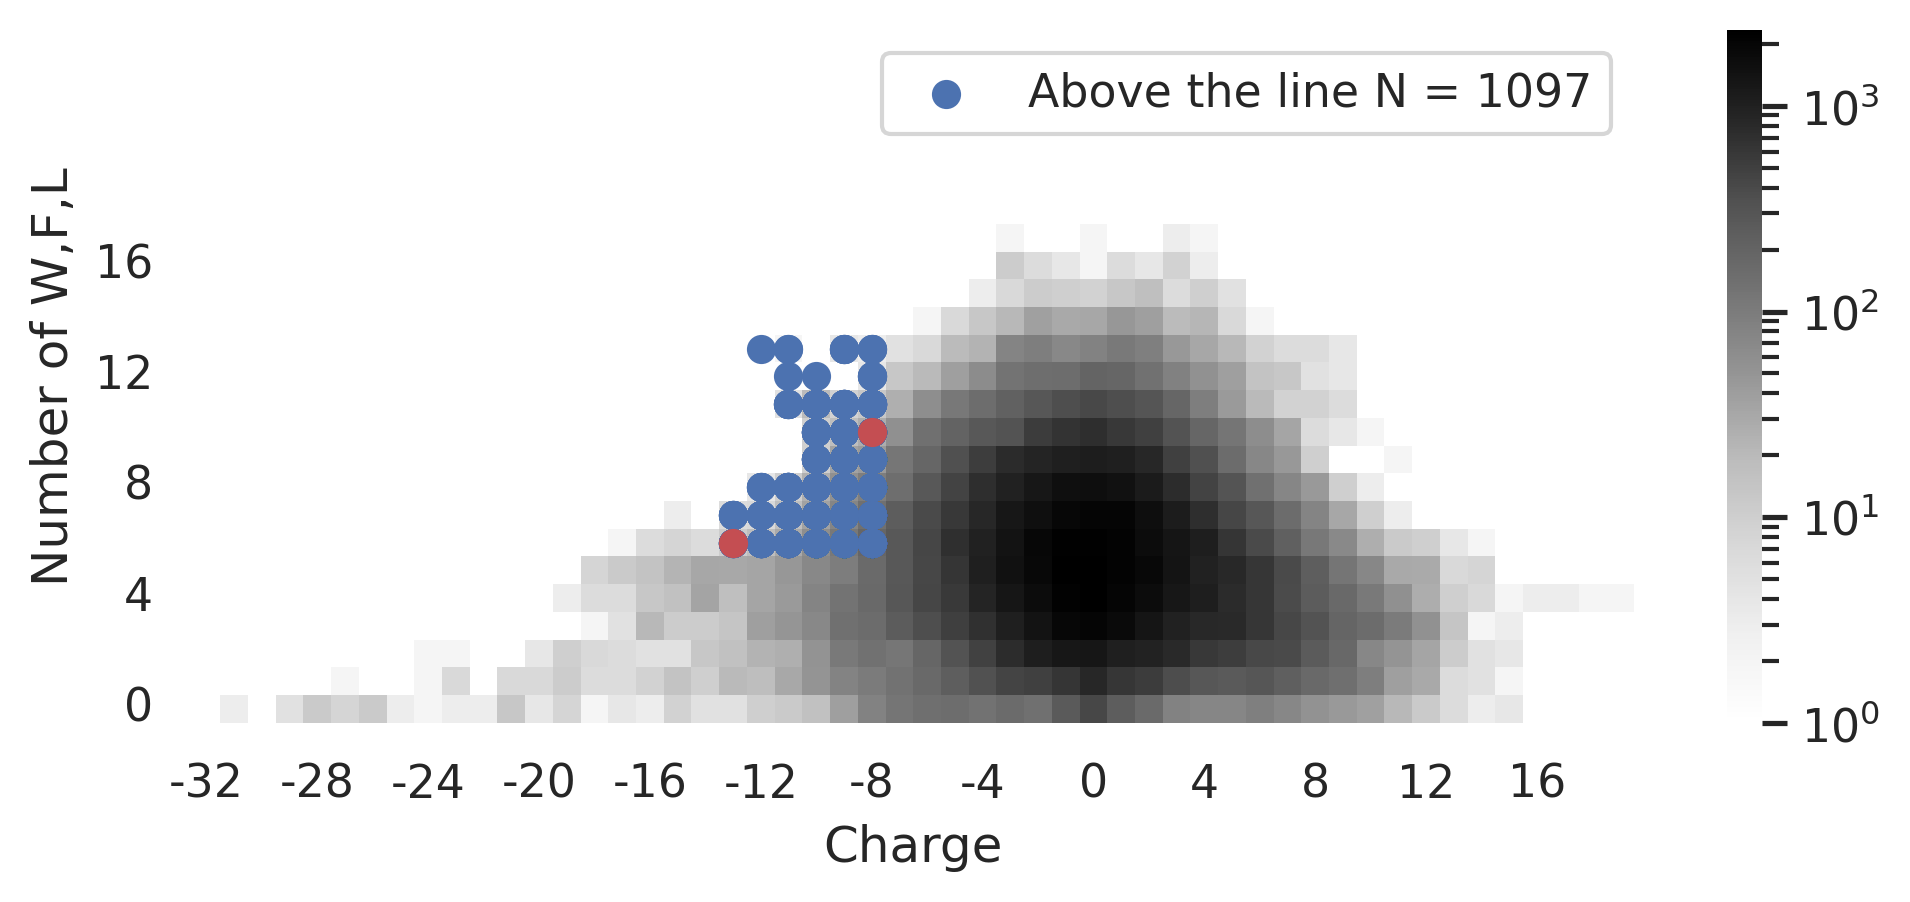

In [7]:
%%time

improved = AD_predictor_tools.make_predictions(folder_name="predictions/",
                        inputfilename=fasta_name,
                        slope=1,
                        lower_corner_c='VP16',lower_corner_h=6,
                        upper_corner_c=-8,upper_corner_h='CITED2',
                        LowerCorner_slope1='inf', LowerCorner_slope2=0,
                        UpperCorner_slope1='inf', UpperCorner_slope2='inf',
                        composition=['W','F','L'],
                        window_size=39,
                        window_spacing=1,
                        propset=['Charge','AllHydros'])

In [10]:
improved["uniprotID"] = improved["GeneName"].str.split("|").str[1]
improved[["uniprotID", "Start", "End"]]

,uniprotID,Start,End
0,P33400,128,172
1,P33400,520,618
2,P13574,229,341
3,P53968,504,543
4,P21192,28,86
...,...,...,...
99,P38830,10,49
100,P14681,310,368
101,P32896,449,505
102,P26370,358,396


In [12]:
improved[["uniprotID", "Start", "End"]].to_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/consensus_AD_predictor/output/yeast_TFs_preds/cleaned/composition.csv")

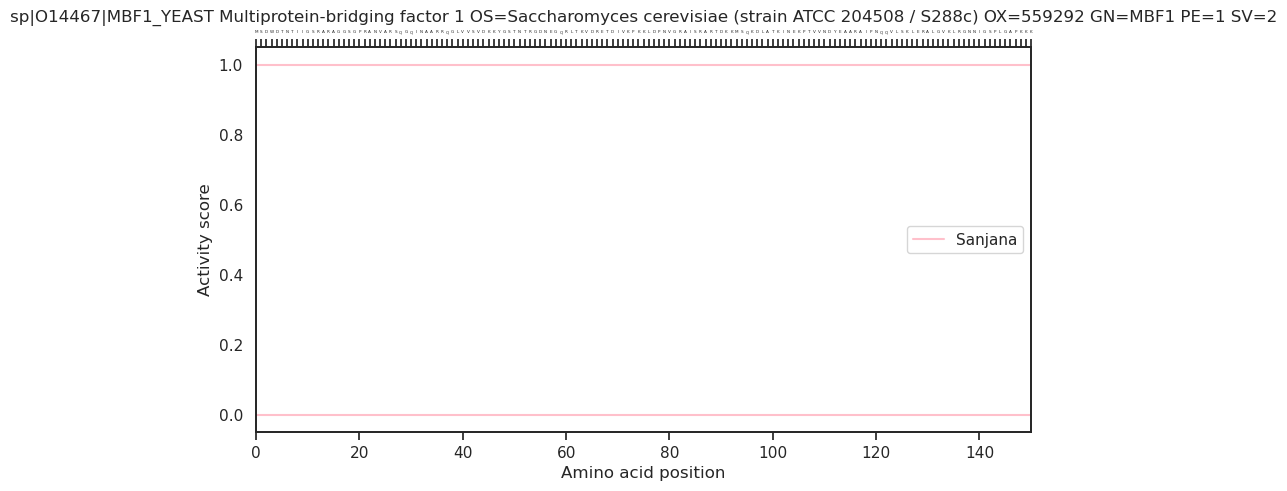

KeyboardInterrupt: 

In [9]:
pdf = matplotlib.backends.backend_pdf.PdfPages(output_dir + "/Sanjana_traces.pdf")

for key,val in recs.items():
    sequence = val
    selected = improved[improved.GeneName == key]
    sanjana_preds = np.zeros(len(sequence))
    for start, end, length in list(zip(selected.Start, selected.End, selected.Length)):
        sanjana_preds[start:end] = np.ones(length)

    fig, ax = plt.subplots(figsize=(10,5))

    # Plot activity trace and activity threshold
    ax.plot(np.arange(len(sequence)), sanjana_preds, c='pink', label='Sanjana')
    ax.plot([0, len(sequence)-1], [1, 1], '-', c='pink')

    ax.set_title(key)
    ax.legend()
    ax.margins(x=0)

    ax.set_xlabel('Amino acid position')
    ax.set_ylabel('Activity score')

    # Plot protein sequence on a secondary x-axis
    # Comment out this block of code if it looks too messy for you
    ax2 = ax.twiny()
    ax2.set_xticks(np.arange(len(sequence)))
    ax2.set_xticklabels([aa for aa in sequence], fontsize=3)

    pdf.savefig()
    plt.show()
    
pdf.close()

# STOP HERE

Using existing Tiling DF at ../data/TilingDFs/LambertTFs_size_39_space_1_AAs_W,F,L.csv
There are 1608 proteins
Using existing Tiling DF at ../data/TilingDFs/LambertTFs_size_39_space_1_AAs_W,F,Y,M,L,Q.csv
544       6
545       6
546       6
547       6
548       6
         ..
874946    6
874947    6
874948    6
874949    6
874950    6
Name: AllHydros, Length: 5764, dtype: int64
seaborn adjustment: -39
There are 5764 regions of length 39 AA as extreme or more than this AD
These regions come from 443 proteins

---
There are 546 predicted candidate AD regions on 443 TFs
There are 1608 proteins
1608
0      sp|Q9NS37|ZHANG_HUMAN
1      sp|Q8IVP9|ZN547_HUMAN
2       sp|Q16621|NFE2_HUMAN
3      sp|Q8N859|ZN713_HUMAN
4      sp|Q12950|FOXD4_HUMAN
               ...          
541     sp|O75030|MITF_HUMAN
542    sp|Q9P0L1|ZKSC7_HUMAN
543    sp|P35638|DDIT3_HUMAN
544    sp|Q5VUA4|ZN318_HUMAN
545    sp|Q96K83|ZN521_HUMAN
Name: GeneName, Length: 546, dtype: object
Saving output to: ../output/predicti

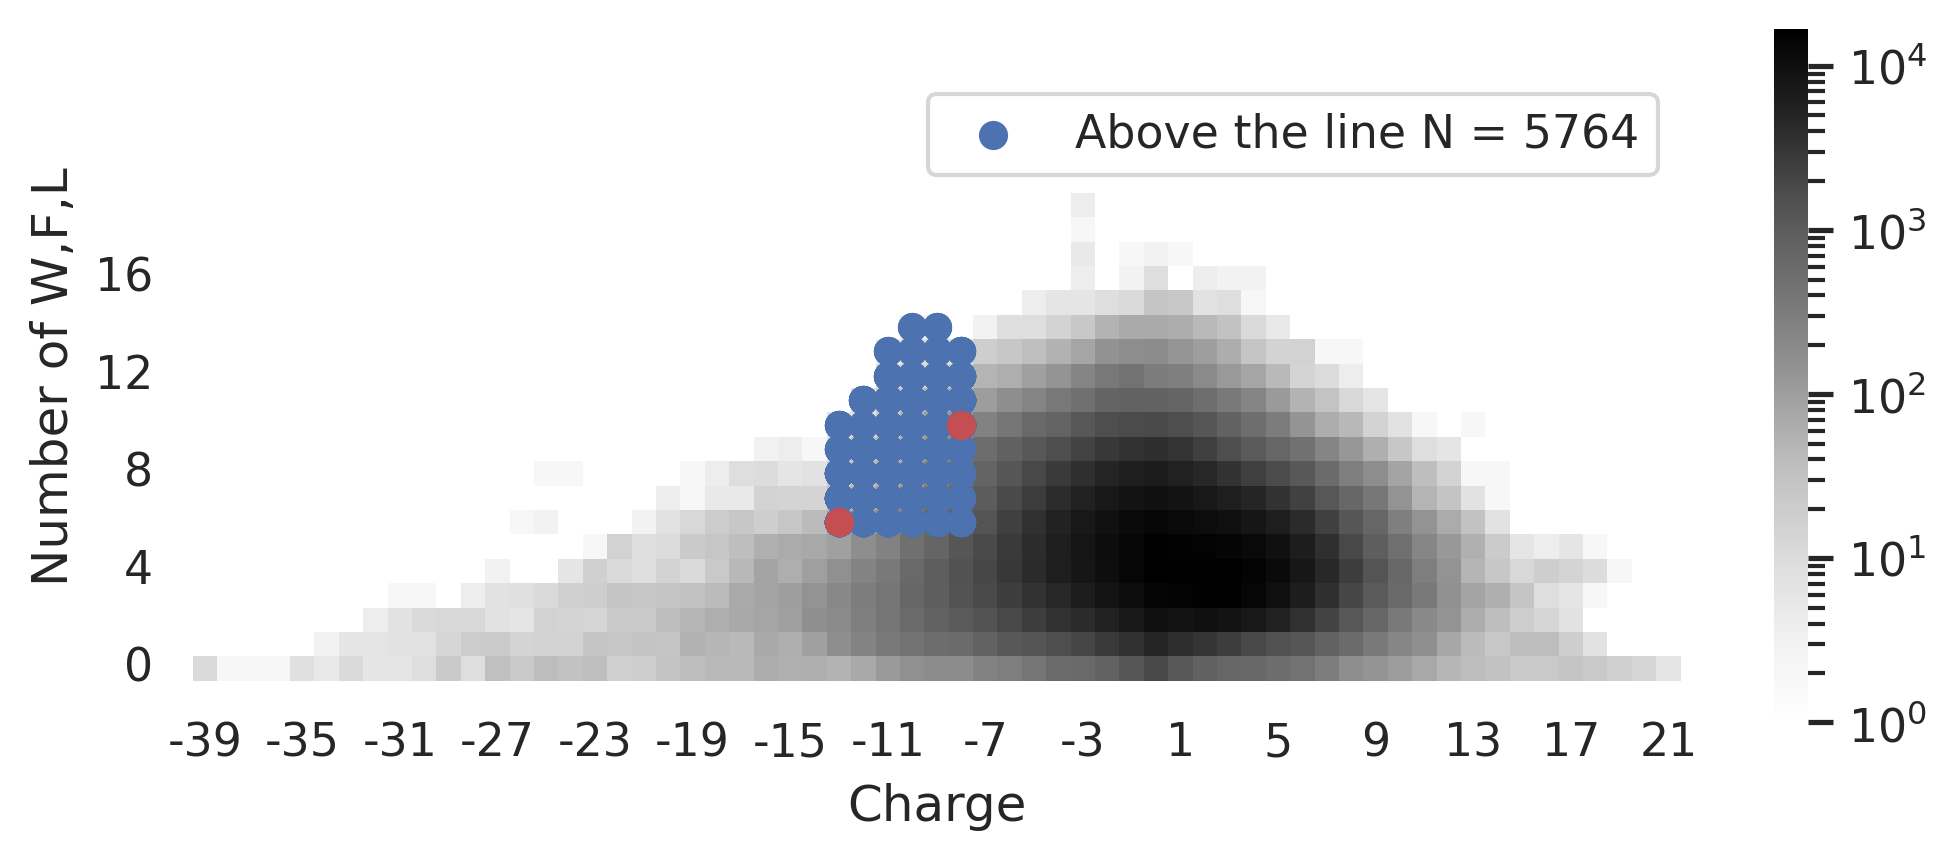

In [2]:
improved = AD_predictor_tools.make_predictions(folder_name="predictions/",
                        inputfilename='../data/LambertTFs.fasta',
                        slope=1,
                        lower_corner_c='VP16',lower_corner_h=6,
                        upper_corner_c=-8,upper_corner_h='CITED2',
                        LowerCorner_slope1='inf', LowerCorner_slope2=0,
                        UpperCorner_slope1='inf', UpperCorner_slope2='inf',
                        composition=['W','F','L'],
                        window_size=39,
                        window_spacing=1,
                        propset=['Charge','AllHydros'])

In [3]:
improved

,GeneName,Start,End,Length,RegionType,ProteinRegionSeq
0,sp|Q9NS37|ZHANG_HUMAN,72,155,83,Prediction,VAVRAPSPEEMEEEAIASLPGEETEDMDFLSGLELADLLDPRQPDW...
1,sp|Q8IVP9|ZN547_HUMAN,22,61,39,Prediction,EEWGHLDEAQRLLYRDVMLENLALLSSLGCCHGAEDEEA
2,sp|Q16621|NFE2_HUMAN,118,165,47,Prediction,PLQDPLALLDIGLPAGPPKPQEDPESDSGLSLNYSDAESLELEGTEA
3,sp|Q8N859|ZN713_HUMAN,53,146,93,Prediction,NLVALGYQLCKPEVIAQLELEEEWVIERDSLLDTHPDGENRPEIKK...
4,sp|Q12950|FOXD4_HUMAN,17,72,55,Prediction,RDSDGEDGKIDVLGEEEDEDEEEAASQQFLEQSLQPGLQVARWGGV...
...,...,...,...,...,...,...
541,sp|O75030|MITF_HUMAN,223,263,40,Prediction,DDVIDDIISLESSYNEEILGLMDPALQMANTLPVSGNLID
542,sp|Q9P0L1|ZKSC7_HUMAN,300,340,40,Prediction,LFGVVPGAAETGDVCEDTFKELEGQTSDEEGSRLENDFLE
543,sp|P35638|DDIT3_HUMAN,1,67,66,Prediction,AAESLPFSFGTLSSWELEAWYEDLQEVLSSDENGGTYVSPPGNEEE...
544,sp|Q5VUA4|ZN318_HUMAN,1966,2026,60,Prediction,ETWESPEKPKTEALELQDVHPELTVTIESKALEDFEATDLKVEELT...
